In [1]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from steady_BEM3 import steady_BEM

import numpy as np
import pandas as pd
from steady_BEM3 import steady_BEM
import matplotlib.pyplot as plt
from IPython.display import clear_output
from unsteady_BEM3 import unsteady_BEM_dyn_inflow


# Example of how to use the steady_BEM class

In [2]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 10 # tip speed ratio
Radius = 50
N_blade_sec = 30
NBlades = 3

TipLocation_R =  1
RootLocation_R =  0.2
pitch = 2

airfoil = 'DU_polar.txt'
#read in the polar of the airfoil
data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha_visc = data1['alfa'][:]
polar_cl_visc = data1['cl'][:]
polar_cd_visc = data1['cd'][:]

B = steady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, TSR, N_blade_sec, 
              polar_alpha_visc, polar_cl_visc, polar_cd_visc)
CT,CP, results = B.get_solution(pitch, Uinf)
print('CT: {}'.format(CT))
print('CP: {}'.format(CP))
    

CT: 0.7640241048359778
CP: 0.45811804894324043


In [3]:
#####################################
###### Dynamic stall functions ######
#####################################

    
def time2semichord(time, U, chord):
    return 2*U*time/chord

def semichord2time(s, U, chord):
    return s/2/U*chord

# determining X and Y terms for recursive marching formula for approximation of Duhamel's integral 
def duhamel_approx(Xi,Yi,delta_s,delta_alpha,order=2,A1=0.3,A2=0.7,b1=0.14,b2=0.53):
    # A1=0.165,A2=0.335,b1=0.0455,b2=0.3
    # determine the next values of X and Y, named Xip1 and Yip1
    if order==1:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha
    elif order==2:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha*np.exp(-b1*delta_s/2)
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha*np.exp(-b2*delta_s/2)        
    else:
        Xip1= Xi*np.exp(-b1*delta_s)+A1*delta_alpha*((1+4*np.exp(-b1*delta_s/2)+np.exp(-b1*delta_s))/6)
        Yip1= Yi*np.exp(-b2*delta_s)+A2*delta_alpha*((1+4*np.exp(-b2*delta_s/2)+np.exp(-b2*delta_s))/6)
    
    return Xip1,Yip1

# define function for circulatory force, potential flow
def circulatory_normal_force(dCn_dalpha,alpha_equivalent,alpha0):
    return dCn_dalpha*(alpha_equivalent-alpha0)

# deficiency function for non-circulatory normal force
def deficiency_function(Dnoncirc_i,delta_dalpha_dt,delta_t,chord,asound=343,kalpha=0.75):
    # a sound is the speed of sound
    TI=chord/asound
    Dnoncirc_ip1 = Dnoncirc_i*np.exp(-delta_t/(kalpha*TI))+delta_dalpha_dt*np.exp(-delta_t/(2*kalpha*TI))
    return Dnoncirc_ip1

# non-circulatory normal force
def non_circulatory_normal_force(dalpha_dt,chord,Uinf,Dnoncirc,kalpha=0.75):
    return 4*kalpha*chord/Uinf*(dalpha_dt-Dnoncirc)
    
# definition of a function for the trailing edge separation point "f"
def f_trailing_edge_separation_point(alpha, a1=7,a2=15,a3=21):
    # receives alpha in radians, converts to degrees
    alphadeg = alpha*180/np.pi
    if alphadeg<=a1:
        f=1
    elif ((alphadeg>a1) and (alphadeg<=a2)):
        f= 1 - .8*((alphadeg-a1)/(a2-a1))
    elif ((alphadeg>a2) and (alphadeg<a3)):
        f= .2 *(1- ((alphadeg-a2)/(a3-a2))**.3)
    else:
        f=0
    return f

# we will now determine the effect of the pressure lag in terms of onset of the separation point
def pressure_lag_deficiency(Dpress_i,delta_s, delta_CNpot, Tp=1.7):
    return Dpress_i*np.exp(-delta_s/Tp)+ delta_CNpot*np.exp(-delta_s/2/Tp) 

## we will now implement a delay function for separation point for boundary layer lag effects
def boundary_layer_lag_deficiency(Dbl_i,delta_s, delta_fprime, Tf=3.0):
    return Dbl_i*np.exp(-delta_s/Tf)+ delta_fprime*np.exp(-delta_s/2/Tf) 

# we will now setup the non-dimensional vortex-time parameter vortime
# we will setup an equation for vortime, integrating in time
def vortime_function(vortime_i,delta_s,delta_alphaqs, Cnormal_prime, CN1=1.0093):
    if Cnormal_prime>CN1:
        vortime_ip1 = vortime_i + 0.45*delta_s
    else:
        if (delta_alphaqs<0 and vortime_i>0):
            vortime_ip1 = vortime_i + 0.45*delta_s
        else:
            vortime_ip1 = 0 
    
    return vortime_ip1

# we will now define the function for decay of the cumulative normal force due to the presence of the leading edge vortex
def leading_edge_vortex_normal_force(Cnormal_vortex_i,delta_s,delta_Cvortex,vortime,TVL=11,TV=6):
    if (vortime>0.001 and vortime<TVL):
        Cnormal_vortex_ip1=Cnormal_vortex_i*np.exp(-delta_s/TV)+ delta_Cvortex*np.exp(-delta_s/2/TV)      
    else:    
        Cnormal_vortex_ip1=Cnormal_vortex_i*np.exp(-delta_s/TV) 
    return Cnormal_vortex_ip1

###########################################
###### End of Dynamic stall functions######
###########################################
 

In [54]:

def pitt_peters(Ct,vind,Uinf,R,dt,glauert=True ):
    # this function determines the time derivative of the induction at the annulli 
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow, nd dt is the time step
    # it returns the new value of induction vindnew and the time derivative dvind_dt
    # glauert defines if glauert's high load correction is applied
    a=-vind/Uinf # determine the induction coefficient for the time step {i-1}
    Ctn= -CTfunction(a, glauert) # calculate the thrust coefficient from the induction for the time step {i-1}
    dvind_dt =  (Ct-Ctn)/(16/(3*np.pi))*(Uinf**2/R) # calculate the time derivative of the induction velocity
    vindnew = vind + dvind_dt*dt # calculate the induction at time {i} by time integration
    return vindnew, dvind_dt

def oye_dynamic_inflow(vz, Ct1, Ct2, vint, Uinf, R, r,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Øye dynamic inflow model
    # Ct is the thrust coefficient on the actuator, vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # r is the radial position of the annulus. vqs is the quasi-steady value from BEM, 
    #vint is an intermediate value and vz is the induced velocity
    
    # calculate  quasi-steady induction velocity
    vqst1=-ainduction(-Ct1)*Uinf

    # calculate current induction factor
    a=-vz/Uinf

    # calculate time scales of the model
    t1 = 1.1/(1-1.3*a)*R/Uinf
    t2 = (0.39-0.26*(r/R)**2)*t1

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
        
    #calculate time derivative of intermediate velocity
    dvint_dt= (vqst1+ (vqst2-vqst1)/dt*0.6*t1 - vint)/t1

    # calculate new intermediate velocity
    vint2 = vint +dvint_dt*dt
    
    #calculate time derivaive of the induced velocity
    dvz_dt = ((vint+vint2)/2-vz)/t2
    
    #calculate new induced velocity
    vz2 = vz +dvz_dt*dt
    
    return vz2, vint2

def larsenmadsen(vz, Ct2, Uinf, R,dt,glauert=True):
    # this function determines the time derivative of the induction at the annulli
    # using the Larsen-Madsen dynamic inflow model
    # Ct2 is the thrust coefficient on the actuator at the next time step, 
    # vind is the induced velocity, 
    # Uinf is the unperturbed velocity and R is the radial scale of the flow,
    # R is the radius. vqst2 is the quasi-steady value from momentum theory, 
    
    # calculate velocity wake 
    Vwake=Uinf+vz

    # calculate time scales of the model
    t1 = 0.5*R/Vwake

    # calculate next-time-step quasi-steady induction velocity
    vqst2=-ainduction(-Ct2)*Uinf
    
    #calculate new induced velocity
    vz2 = vz*np.exp(-dt/t1)+vqst2*(1-np.exp(-dt/t1))
    
    return vz2


def CTfunction(a, glauert = True):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(j, time, alpha_time, vnorm, vtan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd, 
                     dpitch_dt, dhplg_dt, dCn_da, alpha0, alphaqs, dyn_stall, case): #P: alpha_time alle angles of attack tot j
    #dyn_stall = True or False, case for 
    """
    calculates the load in the blade element
    """
    dt = time[1]-time[0]
    vmag2 = vnorm**2 + vtan**2
    W = np.sqrt(vmag2)
    inflowangle = np.arctan2(vnorm,vtan)
    # from now on, everything is in radians
    alpha = twist*np.pi/180 + inflowangle
    alpha_time[j] = alpha
    if dyn_stall:
        
        # calculate quasi-steady alpha
#         alphaqs = alpha_time
#         dalphaqs_dt=np.gradient(alphaqs,time) # calculate the time derivative of the quasi-steady alpha
        dalphaqs_dt = np.zeros(len(alphaqs))
        dalphaqs_dt[0] = (alphaqs[1]-alphaqs[0])/dt
        
        dalphaqs_dt[1:] = np.diff(alphaqs)/dt
        
        
        
        # determine alpha equivalent
        sarray = time2semichord(time, W , chord)
        # define arrays for X,Y and alpha_equivalent
        global Xarray, Yarray
        Xarray=np.zeros(np.shape(time))
        Yarray=np.zeros(np.shape(time))
        # march solution in time for alpha_eq
        for i,val in enumerate(time[:-1]):
            Xarray[i+1],Yarray[i+1]=duhamel_approx(Xarray[i],Yarray[i],
                                                   sarray[i+1]-sarray[i],
                                                   alphaqs[i+1]-alphaqs[i])
        alpha_eq=alphaqs-Xarray-Yarray
        
        # determine deficiency function for non-circulatory loading
        Dnoncirc=np.zeros(np.shape(time))
        # march solution in time
        for i,val in enumerate(time[:-1]):
            Dnoncirc[i+1]=deficiency_function(Dnoncirc[i],dalphaqs_dt[i+1]-dalphaqs_dt[i],dt,chord)
        
        # determine normal load coefficients
        Cnormal_circ = circulatory_normal_force(dCn_da,alpha_eq,alpha0)
        Cnormal_noncirc =  non_circulatory_normal_force(dalphaqs_dt,chord,W,Dnoncirc)
        Cnormal_noncirc = 0
        Cnormal_p = Cnormal_circ+Cnormal_noncirc
        
        # determine trailing edge separation
        f_te = f_trailing_edge_separation_point(alpha)
        
        # determine pressure lag deficiency
        Dpress = np.zeros(np.shape(time))
        # we will now do the time marching to solve for the pressure lag deficiency function 
        for i,val in enumerate(time[:-1]):
            Dpress[i+1] = pressure_lag_deficiency(Dpress[i],sarray[i+1]-sarray[i], Cnormal_p[i+1]-Cnormal_p[i])
        
        # determine Cnprime
        Cnormal_prime = Cnormal_p-Dpress
        # and based on this Cnormal_prime, we determine a new equivalent angle of attack 
        # to determine the onset of trailing edge separation
        alpha_f = Cnormal_prime/dCn_da+alpha0
        
        # we use this equivalent angle of attack alpha_f to determine a new trailign edge separation point effect f_prime
        fprime = np.zeros(np.shape(time))
        for i,val in enumerate(time):
            fprime[i]  = f_trailing_edge_separation_point(alpha_f[i])
        
        # we need to define an array for the boundary layer lag deficiency function
        Dbl = np.zeros(np.shape(time))

        # we will now do the time marching to solve for the boundary layer lag deficiency function 
        for i,val in enumerate(time[:-1]):
            Dbl[i+1] = boundary_layer_lag_deficiency(Dbl[i],sarray[i+1]-sarray[i], fprime[i+1]-fprime[i])

        # we now determine the a new expression of fprimeprime due to the boundary layer lag
        fprimeprime = fprime-Dbl

        ## we can now determine the normal force due to trailing edge boundary layer separation
        Cnormal_f = dCn_da*((1+np.sqrt(fprimeprime))/2)**2*(alpha_eq-alpha0)+ Cnormal_noncirc
        print(alpha_eq,alpha0)
        # Case specific. Cases can be "all_modules" or "no_leading_edge_separation"
        if case=='all_modules':
            # we need to define an array for the non-dimensional vortex-time parameter vortime
            vortime = np.zeros(np.shape(time))

            # we will now do the time marching to solve for the non-dimensional vortex-time parameter vortime
            for i,val in enumerate(time[:-1]):
                vortime[i+1] = vortime_function(vortime[i],sarray[i+1]-sarray[i],dalphaqs_dt[i+1]-dalphaqs_dt[i], Cnormal_prime[i])

            # determine the increment in normal force due tot he presence of a vertex
            Cvortex=Cnormal_circ*(1 - ( ((1+np.sqrt(fprimeprime))/2)**2  ) )


            # We will now solve for the cumulative normal force due to the leadign edge vortex by marching in time.
            # First, we will define the array

            Cnormal_vortex = np.zeros(np.shape(time))
            Cnormal_vortex[0]=Cvortex[0]

            for i,val in enumerate(time[:-1]):
                Cnormal_vortex[i+1] = leading_edge_vortex_normal_force(Cnormal_vortex[i],sarray[i+1]-sarray[i], 
                                                                       Cvortex[i+1]-Cvortex[i],vortime[i])
            Cnormal_total = Cnormal_f + Cnormal_vortex
            cl = Cnormal_total[j]
            
        elif case=='no_leading_edge_separation':
            # return the Cl of the normal forces due to trailing edge Bl separation
            cl = Cnormal_f[j]
        else:
            raise ValueError('case {} is not a valid case'.format(case))
            
    else:
#         alphaqs = np.zeros(np.shape(time))
        alpha_eq = np.zeros(np.shape(time))
        Dnoncirc = np.zeros(np.shape(time))
        cl = np.interp(alpha*180/np.pi, polar_alpha, polar_cl)
    cd = np.interp(alpha*180/np.pi, polar_alpha, polar_cd)
    
    lift = 0.5*vmag2*cl*chord
    drag = 0.5*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma, alpha, alpha_eq[j-1], Dnoncirc[j-1]



In [50]:
def solveStreamtube(U_time, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades,
                    chord, twist_no_pitch, polar_alpha, polar_cl, polar_cd, time, 
                    pitch_time, initial_cond, hplg_time, dCn_da, alpha0, alphaqs_time, dyn_stall, case, model='pitt_peters' ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    U_time - wind speed over time
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    
    initial_cond = np.array([a_init, ap_init, fnorm_init, ftan_init, gamma_init, Ct_init, Prandtl_init])
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables as the initial conditions
    a = initial_cond[0] # axial induction
    aline = initial_cond[1] # tangential induction factor
    
    #define the maximum number of iterations per time step
    Niterations = 100
    
    #define some empty arrays which house the results in time
    a_time = np.zeros(len(time))
    ap_time = np.zeros(len(time))
    fnorm_time = np.zeros(len(time))
    ftan_time = np.zeros(len(time))
    gamma_time = np.zeros(len(time))
    Ct_time = np.zeros(len(time))
    alpha_time = np.zeros(len(time))
#     alphaqs_time = np.zeros(len(time))
    alpha_eq_time = np.zeros(len(time))
    Dnoncirc_time = np.zeros(len(time))
    
    #add the initial conditions to these arrays
    a_time[0] = initial_cond[0]
    ap_time[0] = initial_cond[1]
    fnorm_time[0] = initial_cond[2]
    ftan_time[0] = initial_cond[3]
    gamma_time[0] = initial_cond[4]    
    Ct_time[0] = initial_cond[5]
    Prandtl = initial_cond[6]
    alpha_time[0] = initial_cond[7]*np.pi/180
    
    #find the value for dt
    dt = time[1]-time[0]
    
    Erroriterations =0.00001*dt #relative change in induction factor
    
    #if the model is oye, a intermediate velocity is required, multiply with the value
    #of the Prandtl tip corrections to make sure the correct induced velocity is calculated
    if model == 'oye':
        vint = -a_time[0]*U_time[0]*Prandtl
    
    #run through the time vector
    for j in range(1,len(time)):
        #add the pitch of the current timestep to the twist
        twist = twist_no_pitch+pitch_time[j]/np.pi*180

        # calculate the derivatives of the pitching and plunging motion
        dpitch_dt=np.gradient(pitch_time,time) # calculate the time derivative of pitch
        dhplg_dt=np.gradient(hplg_time,time) # plunge velocity

        for i in range(Niterations):
            # ///////////////////////////////////////////////////////////////////////
            # // this is the block "Calculate velocity and loads at blade element"
            # ///////////////////////////////////////////////////////////////////////
            Urotor = U_time[j]*(1-a) # axial velocity at rotor
            Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
            
            # calculate loads in blade segment in 2D (N/m)
#             temp_res = loadBladeElement(j, time, alpha_time, Urotor, Utan, r_R,chord, 
#                                           twist, polar_alpha, polar_cl, polar_cd, dpitch_dt,
#                                           dhplg_dt, dCn_da, alpha0, alphaqs_time*np.pi/180, False, case)
            
            [fnorm, ftan, gamma, alpha, alpha_eq, 
             Dnoncirc] = loadBladeElement(j, time, alpha_time, Urotor, Utan, r_R,chord, 
                                          twist, polar_alpha, polar_cl, polar_cd, dpitch_dt,
                                          dhplg_dt, dCn_da, alpha0, alphaqs_time*np.pi/180, dyn_stall, case)
            
            load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
#             print(fnorm,temp_res[0])
            # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)

            # ///////////////////////////////////////////////////////////////////////
            # //the block "Calculate velocity and loads at blade element" is done
            # ///////////////////////////////////////////////////////////////////////

            # ///////////////////////////////////////////////////////////////////////
            # // this is the block "Calculate new estimate of axial and azimuthal induction"
            # ///////////////////////////////////////////////////////////////////////
            # // calculate thrust coefficient at the streamtube 
            CT = load3Daxial/(0.5*Area*U_time[j]**2)

            # calculate new axial induction, accounting for Glauert's correction
            #anew =  ainduction(CT)
            #note that the vind is multiplied with the Prandtl tip correction to make sure the correct
            #value for vind by the force produced by the blade section is calculated, this will later 
            #be corrected again with the Prandtl tip correction.
            if model == 'pitt_peters':
                vind,dvind_dt = pitt_peters(np.array([-CT]),np.array([-a_time[j-1]*U_time[j-1]*Prandtl]),U_time[j],Radius,dt)
            elif model == 'oye':
                vind,vint_new=oye_dynamic_inflow(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-Ct_time[j-1]]), np.array([-CT]), vint, U_time[j], Radius, r_R*Radius,dt) 
            elif model == 'larsen_madsen':
                vind = larsenmadsen(np.array([-a_time[j-1]*U_time[j-1]*Prandtl]), np.array([-CT]), U_time[j], Radius,dt)
            else:
                raise ValueError('Model not recognized')
            
            #find the new axial induction factor 
            anew = -vind[0]/U_time[j]
            
            # correct new axial induction with Prandtl's correction
            Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/U_time[j], NBlades, anew);

            if (Prandtl < 0.0001):  
                Prandtl = 0.0001 # avoid divide by zero
                            
            anew = anew/Prandtl # correct estimate of axial induction
            a = 0.0*a+1.0*anew # since the initial guess of this timestep will be the value for induction of 
                               # the previous timestep, the weigthing is not done to speed up the code
                            
            # calculate aximuthal induction
            aline_new = ftan*NBlades/(2*np.pi*U_time[j]*(1-a)*Omega*2*(r_R*Radius)**2)
            aline_new =aline_new/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
            aline = aline_new
#            aline = aline*0.95+aline_new*0.05
            # ///////////////////////////////////////////////////////////////////////////
            # // end of the block "Calculate new estimate of axial and azimuthal induction"
            # ///////////////////////////////////////////////////////////////////////
            
            #// test convergence of solution, by checking convergence of axial induction
            if (np.abs((a-anew)/a) < Erroriterations): 
                # print("iterations")
                # print(i)
                break
        #if the model is oye, define the new intermediate velocity from this timestep after converged
        if model == 'oye':
            vint = vint_new*1
        #notify the user if the timestep has not converged
        if i == Niterations-1:
            print('Not converged')
        #save the results from this timestep before moving on to the next
        a_time[j] = a
        ap_time[j] = aline
        fnorm_time[j] = fnorm
        ftan_time[j] = ftan
        gamma_time[j] = gamma
        Ct_time[j] = CT
        alpha_time[j] = alpha
#         alphaqs_time[j] = alphaqs
        alpha_eq_time[j] = alpha_eq
        Dnoncirc_time[j] = Dnoncirc
    # fix the first entry
#     alphaqs_time[0] = alphaqs_time[1]
    print(alpha_eq_time[0])
    alpha_eq_time[0] = alpha_eq_time[1]
    Dnoncirc_time[0] = Dnoncirc_time[1]
    #return the results
    return [a_time,ap_time,fnorm_time,ftan_time,gamma_time,Ct_time, alpha_time, 
            alphaqs_time, alpha_eq_time, Dnoncirc_time]




In [36]:
class unsteady_BEM:
    def __init__(self, airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, 
                 TSR, N_blade_sec, polar_alpha, polar_cl, polar_cd, alpha0, spacing = 'cosine'):
        self.airfoil = airfoil
        self.NBlades = NBlades
        self.Radius = Radius
        self.Uinf = Uinf
        self.Omega = TSR*Uinf/Radius
        self.N_blade_sec = N_blade_sec
        self.RootLocation_R = RootLocation_R
        self.TipLocation_R = TipLocation_R
        #create the blade division
        if spacing == 'cosine':
            beta_cosine = np.linspace(0,np.pi,N_blade_sec+1)
            self.r_R_dist = RootLocation_R+(TipLocation_R-RootLocation_R)/2*(1-np.cos(beta_cosine))
        elif spacing == 'uniform':
            self.r_R_dist = np.linspace(RootLocation_R,TipLocation_R,N_blade_sec+1)
        else:
            raise ValueError('Spacing method not recognized, please select either "cosine" or "uniform"')
        
        self.r_R_cent = np.zeros(N_blade_sec)
        #get the normalized radial locations of the blade sections
        for i in range(N_blade_sec):
            self.r_R_cent[i] = (self.r_R_dist[i]+self.r_R_dist[i+1])/2
        
        #define the twist distribution without pitch as well as the chord distribution
        self.twist_no_pitch = -14*(1-self.r_R_cent)
        self.chord_cent = 3*(1-self.r_R_cent)+1
        
        # set the polars
        self.polar_alpha = polar_alpha
        self.polar_cl = polar_cl
        self.polar_cd = polar_cd
        self.alpha0 = alpha0*np.pi/180
        
        #initialize the steady BEM class
        self.B_steady = steady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius,
                                   Uinf, TSR, N_blade_sec, polar_alpha, polar_cl, polar_cd,
                                   spacing=spacing)
        #initialize the unsteady BEM class to be able to find the quasi-steady aoa
        airfoil = 'DU_polar.txt'
        self.B_unsteady_dyn_inflow = unsteady_BEM_dyn_inflow(airfoil, TipLocation_R, RootLocation_R, NBlades, 
                                                        Radius, Uinf, TSR, N_blade_sec,polar_alpha,polar_cl,polar_cd, 
                                                        spacing = spacing)

        self.pitch_ct = np.genfromtxt('pitch_ct.csv', delimiter=',')
        
    def find_pitch(self, CT):
        #find the value of the pitch given the steady CT
        return np.interp(CT, self.pitch_ct[:,0], self.pitch_ct[:,1])
    
    #finction that calculates the solution give a time vector with the associated values for steady CT
    #inflow models can be: pitt_peters,oye,larsen_madsen
    #step change can be: CT or U_inf
    def get_solution(self, time_vec, CT_time, U_time, inflow_model = 'pitt_peters'):
        self.time_vec = time_vec
        
        #using the steady BEM class instance, find the value for the pitch in time to reach the 
        #given steady CT
        self.pitch_time = self.find_pitch(CT_time)  
        self.U_time = U_time
        self.inflow_model = inflow_model
        
        #find the solution for the initial conditions with the steady solution
        start_CT,start_CP,start_results = self.B_steady.get_solution(self.pitch_time[0], self.U_time[0])   
        
        #define some empty arrays that will house the results
        a_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        ap_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        fnorm_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        ftan_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        gamma_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        Ct_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        
        #find the width of each blade section
        dr = (self.r_R_dist[1:]-self.r_R_dist[:-1])*self.Radius
        
        #some empty arrays that house the absolute values for the thrust and the moment
        T_res = np.zeros([self.N_blade_sec,len(time_vec)])
        M_res = np.zeros([self.N_blade_sec,len(time_vec)])
        
        #run through each blade section and calculate the solution in time
        for i in range(self.N_blade_sec):
            #clear_output(wait=True)
            print('we are at {}%'.format(round(i/self.N_blade_sec*100, 2)))
            #find the initial conditions
            initial_cond = np.array([start_results[i,0], start_results[i,1], start_results[i,3], 
                                     start_results[i,4], start_results[i,5], start_results[i,6],
                                     start_results[i,7], start_results[i,8]])
            #call the function solveStreamtube with the given initial conditions and pitch in time
            a_time_res[i,:],ap_time_res[i,:],fnorm_time_res[i,:],ftan_time_res[i,:],gamma_time_res[i,:],Ct_time_res[i,:] = solveStreamtube(self.U_time, 
                       self.r_R_dist[i], self.r_R_dist[i+1], self.RootLocation_R, self.TipLocation_R , 
                       self.Omega, self.Radius, self.NBlades, self.chord_cent[i], self.twist_no_pitch[i], 
                       self.polar_alpha, self.polar_cl, self.polar_cd, time_vec, self.pitch_time,
                       initial_cond, model=inflow_model )
            #save the absolute value for thrust and moment for each blade section
            T_res[i,:] = fnorm_time_res[i,:]*dr[i]
            M_res[i,:] = ftan_time_res[i,:]*dr[i]*self.r_R_cent[i]*self.Radius
        #sum all the values for thrust and moment along axis=0 to find the total thrust in time and normalize
        CT_res = np.sum(T_res,axis=0)*self.NBlades/(0.5*self.Uinf**2*np.pi*self.Radius**2)
        CP_res = np.sum(M_res,axis=0)*self.NBlades*self.Omega/(0.5*self.Uinf**3*np.pi*self.Radius**2)
        #add the inital conditions to the CT and CP
        CT_res[0] = start_CT
        CP_res[0] = start_CP
        #return the results
        return a_time_res,ap_time_res,fnorm_time_res,ftan_time_res,gamma_time_res,Ct_time_res, CT_res, CP_res        

    # Dynamic stall module
    def get_solution_dyn_stall(self, time_vec, U_time, pitch_time, hplg_time, dCn_da, 
                               dyn_stall, case, inflow_model='pitt_peters'):
        self.time_vec = time_vec
        
        #using the steady BEM class instance, find the value for the pitch in time to reach the 
        #given steady CT
        self.pitch_time = pitch_time
        self.U_time = U_time
        self.inflow_model = inflow_model
        
        #find the quasi-steady solution to get the quasi-steady angle of attack
        CT_time = np.interp(pitch_time/np.pi*180,self.pitch_ct[:,1],self.pitch_ct[:,0])
        
        qs_results = self.B_unsteady_dyn_inflow.get_solution(time_vec, CT_time, U_time, inflow_model = inflow_model)
        alphaqs_time_res = qs_results[-1]
        
        start_CT,start_CP,start_results = self.B_steady.get_solution(self.pitch_time[0]*180/np.pi, self.U_time[0])        
#         start_CT = start_CT*(self.Uinf/self.U_time[0])**2
        
        #define some empty arrays that will house the results
        a_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        ap_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        fnorm_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        ftan_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        gamma_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        Ct_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        alpha_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
#         alphaqs_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        alpha_eq_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        Dnoncirc_time_res = np.zeros([self.N_blade_sec,len(time_vec)])
        #find the width of each blade section
        dr = (self.r_R_dist[1:]-self.r_R_dist[:-1])*self.Radius
        
        #some empty arrays that house the absolute values for the thrust and the moment
        T_res = np.zeros([self.N_blade_sec,len(time_vec)])
        M_res = np.zeros([self.N_blade_sec,len(time_vec)])
        
        #run through each blade section and calculate the solution in time
        for i in range(self.N_blade_sec):
            #clear_output(wait=True)
            print('we are at {}%'.format(np.round(i/self.N_blade_sec*100, 2)))
            #find the initial conditions
            initial_cond = np.array([start_results[i,0], start_results[i,1], start_results[i,3], 
                                     start_results[i,4], start_results[i,5], start_results[i,6],
                                     start_results[i,7], start_results[i,8]])
            #call the function solveStreamtube with the given initial conditions and pitch in time
            [a_time_res[i,:],ap_time_res[i,:],fnorm_time_res[i,:],ftan_time_res[i,:],
             gamma_time_res[i,:],Ct_time_res[i,:],alpha_time_res[i,:], alphaqs_time_res[i,:],
             alpha_eq_time_res[i,:], Dnoncirc_time_res[i,:]] = solveStreamtube(self.U_time, 
                       self.r_R_dist[i], self.r_R_dist[i+1], self.RootLocation_R, self.TipLocation_R , 
                       self.Omega, self.Radius, self.NBlades, self.chord_cent[i], self.twist_no_pitch[i], 
                       self.polar_alpha, self.polar_cl, self.polar_cd, time_vec, self.pitch_time,
                       initial_cond, hplg_time, dCn_da, self.alpha0, alphaqs_time_res[i,:], dyn_stall, case, model=inflow_model )
            #save the absolute value for thrust and moment for each blade section
            T_res[i,:] = fnorm_time_res[i,:]*dr[i]
            M_res[i,:] = ftan_time_res[i,:]*dr[i]*self.r_R_cent[i]*self.Radius
        #sum all the values for thrust and moment along axis=0 to find the total thrust in time and normalize
        CT_res = np.sum(T_res,axis=0)*self.NBlades/(0.5*self.Uinf**2*np.pi*self.Radius**2)
        CP_res = np.sum(M_res,axis=0)*self.NBlades*self.Omega/(0.5*self.Uinf**3*np.pi*self.Radius**2)
        #add the inital conditions to the CT and CP
        CT_res[0] = start_CT
        CP_res[0] = start_CP
        #return the results
        return [a_time_res,ap_time_res,fnorm_time_res,ftan_time_res,gamma_time_res,
                Ct_time_res, CT_res, CP_res, alpha_time_res, alphaqs_time_res, 
                alpha_eq_time_res, Dnoncirc_time_res]


# Example of how to use the unsteady case

In [56]:
# define flow conditions
Uinf = 10 # unperturbed wind speed in m/s
TSR = 8 # tip speed ratio
Radius = 50 #radius of the rotor
N_blade_sec = 5  #number of blade sections of one rotor blade
NBlades = 3 #number of blades
TipLocation_R =  1 #normalized location of the tip of the rotor
RootLocation_R = 0.2 #normalized location of the root of the rotor
spacing = 'cosine'  #spacing method to use for the rotor blade, can be 'cosine' or 'uniform'
airfoil = 'DU_polar.txt' #name of the file with the airfoil polars

#read in the polar of the airfoil
data1=pd.read_csv(airfoil, header=0,
                    names = ["alfa", "cl", "cd", "cm"],  sep='\s+')
polar_alpha_visc = data1['alfa'][:]
polar_cl_visc = data1['cl'][:]
polar_cd_visc = data1['cd'][:]
alpha0 = np.interp(0, polar_cl_visc, polar_alpha_visc)

# set the dynamic stall polars
dCn_da = 2*np.pi
polar_alpha = np.arange(-5, 30, 0.1)
polar_cl = dCn_da*polar_alpha*np.pi/180
polar_cd = 0*polar_alpha*np.pi/180
# test polar with trailing edge separation point "f"
CNsep=np.zeros(np.shape(polar_alpha))
for i,val in enumerate(polar_alpha):
    CNsep[i]= dCn_da*(((1+np.sqrt(f_trailing_edge_separation_point(polar_alpha[i]*np.pi/180)))/2)**2)*(polar_alpha[i]-alpha0)*np.pi/180


#initialize the unsteady BEM model, note that for high pitch angles the model might return a warning that is not able
#to converge
B_unsteady = unsteady_BEM(airfoil, TipLocation_R, RootLocation_R, NBlades, Radius, Uinf, 
                          TSR, N_blade_sec, polar_alpha, polar_cl, polar_cd, alpha0)

-1.9456896551724137


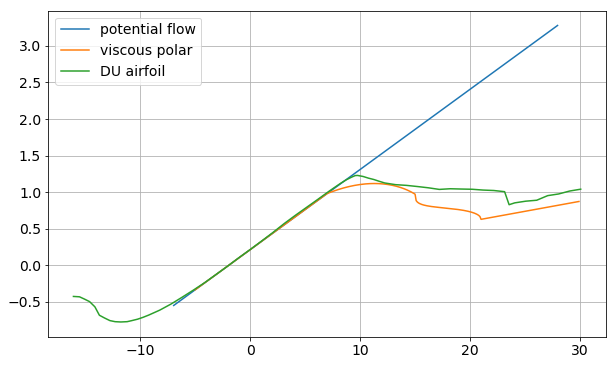

In [50]:
fig = plt.figure(figsize=(10,6))
plt.plot(polar_alpha+alpha0, polar_cl, label='potential flow')
plt.plot(polar_alpha, CNsep, label='viscous polar')
plt.plot(polar_alpha_visc, polar_cl_visc, label='DU airfoil')
plt.grid()
plt.legend()
plt.show()

# Dynamic stall - Sinusoidal change in wind speed

In [38]:
#create the time array
max_time = 30 #upper bound on the time vector
dt = 0.05
time = np.arange(0,max_time,dt)
size = len(time)-1
U1_U0 = 1.0
deltaU = 0.5
omega_R_uinf = 0.3
azimuth = 0*np.pi/180

# create velocity vector
U_time = Uinf*U1_U0 + deltaU*np.cos(omega_R_uinf*time)*np.cos(azimuth)

# pitching motion of the airfoil
omega=0 # frequency of the pitching motion
pitch0 = -5.#0.669
Amplitude_alpha=10/180*np.pi # amplitude of the pitching motion
pitch_t0=pitch0/180*np.pi # pitch at time=0
pitch_time_vec=Amplitude_alpha*np.sin(omega*time)+pitch_t0 # calculate alpha

# plunge motion of the airfoil
omega_plg=0 # frequency of the plunge motion
Amplitude_plg=.3 # amplitude of the plunge motion
hplg_time=Amplitude_plg*np.sin(omega_plg*time) #position


###  1. plot the loading at different locations of the blade

In [55]:
# 1.1 Demonstrate a fully developed cycle for case Dyn 1 
inflow_model = 'pitt_peters'
# parameter names: [parameter]_[model]_[case]

# 1.1.0 fully developed cycle
dyn_stall = True
case='all_modules'
[a_pp_ds,ap_pp_ds,fnorm_pp_ds,ftan_pp_ds,gamma_pp_ds,Ct_pp_ds, CT_pp_ds, CP_pp_ds, 
 alpha_pp_ds,alphaqs_pp_ds,alpha_eq_pp_ds,Dnc_pp_ds]=B_unsteady.get_solution_dyn_stall(time,U_time, pitch_time_vec, hplg_time, dCn_da, dyn_stall, case, inflow_model = inflow_model)

# 1.1.1 Compare with the loads assuming a steady  polar, and discuss the results
dyn_stall = False
case='none'
[a_pp_s,ap_pp_s,fnorm_pp_s,ftan_pp_s,gamma_pp_s,Ct_pp_s, CT_pp_s, CP_pp_s, alpha_pp_s, 
 alphaqs_pp_s,alpha_eq_pp_s, Dnc_pp_s]=B_unsteady.get_solution_dyn_stall(time,U_time, pitch_time_vec, hplg_time, dCn_da, dyn_stall, case, inflow_model = inflow_model)

# 1.1.2 Compare with the loads assuming that there is no leading edge separation, 
# and discuss the results
dyn_stall = True
case = 'no_leading_edge_separation'
[a_pp_le,ap_pp_le,fnorm_pp_le,ftan_pp_le,gamma_pp_le,Ct_pp_le, CT_pp_le, CP_pp_le, alpha_pp_le,
 alphaqs_pp_le, alpha_eq_pp_le, Dnc_pp_le]=B_unsteady.get_solution_dyn_stall(time,U_time, pitch_time_vec, hplg_time, dCn_da, dyn_stall, case, inflow_model = inflow_model)

# 1.1.3 Discuss the effect of spanwise location in the level of unsteadiness


we are at 0.0%
we are at 20.0%
we are at 40.0%
we are at 60.0%
we are at 80.0%
we are at 0.0%
[0.12735139 0.12735115 0.12735019 0.12734766 0.12734289 0.12733561
 0.12732563 0.12731283 0.12729712 0.12727841 0.12725666 0.12723182
 0.12720389 0.12717283 0.12713863 0.1271013  0.12706083 0.12701722
 0.12697049 0.12692063 0.12686766 0.1268116  0.12675246 0.12669025
 0.126625   0.12655672 0.12648544 0.12641118 0.12633395 0.12625379
 0.12617072 0.12608476 0.12599594 0.12590429 0.12580984 0.12571261
 0.12561263 0.12550994 0.12540456 0.12529652 0.12518586 0.1250726
 0.12495678 0.12483843 0.12471759 0.12459428 0.12446854 0.12434041
 0.12420991 0.12407709 0.12394198 0.12380462 0.12366503 0.12352326
 0.12337935 0.12323333 0.12308523 0.1229351  0.12278297 0.12262889
 0.12247288 0.122315   0.12215527 0.12199374 0.12183045 0.12166543
 0.12149873 0.1213304  0.12116046 0.12098896 0.12081594 0.12064144
 0.12046551 0.12028819 0.12010952 0.11992954 0.1197483  0.11956583
 0.11938219 0.11919741 0.11901154 0.

[0.12735139 0.12735115 0.12735018 0.12734764 0.12734284 0.12733551
 0.12732548 0.12731262 0.12729684 0.12727806 0.12725622 0.12723131
 0.12720328 0.12717213 0.12713784 0.1271004  0.12705983 0.12701611
 0.12696927 0.1269193  0.12686622 0.12681004 0.12675078 0.12668846
 0.12662309 0.12655469 0.12648328 0.1264089  0.12633155 0.12625126
 0.12616806 0.12608198 0.12599304 0.12590126 0.12580668 0.12570933
 0.12560923 0.12550641 0.1254009  0.12529274 0.12518195 0.12506857
 0.12495263 0.12483416 0.12471319 0.12458976 0.1244639  0.12433565
 0.12420504 0.1240721  0.12393688 0.12379939 0.1236597  0.12351782
 0.12337379 0.12322766 0.12307945 0.12292922 0.12277698 0.12262279
 0.12246669 0.1223087  0.12214887 0.12198724 0.12182386 0.12165875
 0.12149195 0.12132352 0.12115349 0.12098191 0.1208088  0.12063422
 0.12045821 0.12028081 0.12010206 0.119922   0.11974068 0.11955814
 0.11937442 0.11918958 0.11900364 0.11881666 0.11862867 0.11843973
 0.11824988 0.11805916 0.11786762 0.1176753  0.11748226 0.1172

[0.12735139 0.12735115 0.12735018 0.12734764 0.12734285 0.12733553
 0.12732552 0.12731267 0.1272969  0.12727813 0.12725632 0.12723142
 0.12720341 0.12717228 0.12713801 0.1271006  0.12706005 0.12701636
 0.12696954 0.12691959 0.12686654 0.12681039 0.12675115 0.12668885
 0.12662351 0.12655514 0.12648376 0.1264094  0.12633208 0.12625182
 0.12616865 0.12608259 0.12599368 0.12590193 0.12580738 0.12571005
 0.12560998 0.12550719 0.12540171 0.12529357 0.12518281 0.12506946
 0.12495354 0.1248351  0.12471416 0.12459076 0.12446493 0.1243367
 0.12420611 0.1240732  0.123938   0.12380055 0.12366087 0.12351902
 0.12337502 0.12322891 0.12308073 0.12293051 0.1227783  0.12262414
 0.12246805 0.12231009 0.12215028 0.12198868 0.12182531 0.12166022
 0.12149345 0.12132504 0.12115503 0.12098346 0.12081037 0.12063581
 0.12045982 0.12028243 0.1201037  0.11992366 0.11974236 0.11955983
 0.11937613 0.1191913  0.11900538 0.11881841 0.11863044 0.11844152
 0.11825168 0.11806097 0.11786944 0.11767714 0.1174841  0.11729

[0.12735139 0.12735115 0.12735018 0.12734765 0.12734286 0.12733555
 0.12732555 0.12731271 0.12729696 0.1272782  0.12725641 0.12723152
 0.12720354 0.12717242 0.12713817 0.12710078 0.12706025 0.12701658
 0.12696978 0.12691986 0.12686683 0.1268107  0.12675149 0.12668921
 0.12662389 0.12655554 0.12648419 0.12640985 0.12633256 0.12625232
 0.12616918 0.12608315 0.12599426 0.12590253 0.12580801 0.12571071
 0.12561066 0.12550789 0.12540244 0.12529433 0.12518359 0.12507026
 0.12495437 0.12483595 0.12471503 0.12459166 0.12446585 0.12433765
 0.12420708 0.1240742  0.12393902 0.12380158 0.12366193 0.1235201
 0.12337612 0.12323003 0.12308188 0.12293168 0.12277949 0.12262535
 0.12246928 0.12231134 0.12215155 0.12198997 0.12182662 0.12166155
 0.1214948  0.1213264  0.12115641 0.12098486 0.12081179 0.12063725
 0.12046127 0.1202839  0.12010519 0.11992516 0.11974387 0.11956136
 0.11937768 0.11919286 0.11900695 0.11882    0.11863204 0.11844313
 0.1182533  0.11806261 0.11787109 0.1176788  0.11748577 0.11729

[0.12735139 0.12735115 0.12735018 0.12734765 0.12734287 0.12733557
 0.12732557 0.12731275 0.12729701 0.12727827 0.12725649 0.12723162
 0.12720365 0.12717255 0.12713832 0.12710095 0.12706044 0.12701679
 0.12697001 0.12692011 0.1268671  0.12681099 0.1267518  0.12668955
 0.12662425 0.12655593 0.1264846  0.12641028 0.12633301 0.1262528
 0.12616968 0.12608367 0.1259948  0.12590311 0.1258086  0.12571132
 0.1256113  0.12550856 0.12540313 0.12529504 0.12518433 0.12507102
 0.12495515 0.12483676 0.12471586 0.12459251 0.12446672 0.12433854
 0.124208   0.12407514 0.12393998 0.12380257 0.12366294 0.12352113
 0.12337717 0.1232311  0.12308297 0.12293279 0.12278062 0.1226265
 0.12247045 0.12231253 0.12215276 0.12199119 0.12182786 0.12166281
 0.12149608 0.1213277  0.12115773 0.12098619 0.12081314 0.12063861
 0.12046265 0.1202853  0.12010659 0.11992658 0.11974531 0.11956282
 0.11937914 0.11919434 0.11900844 0.1188215  0.11863356 0.11844465
 0.11825484 0.11806416 0.11787265 0.11768037 0.11748735 0.117293

[0.12735139 0.12735115 0.12735018 0.12734766 0.12734288 0.12733559
 0.1273256  0.12731279 0.12729706 0.12727833 0.12725656 0.12723172
 0.12720376 0.12717268 0.12713847 0.12710111 0.12706062 0.12701699
 0.12697023 0.12692035 0.12686736 0.12681127 0.1267521  0.12668987
 0.1266246  0.12655629 0.12648499 0.12641069 0.12633344 0.12625326
 0.12617016 0.12608417 0.12599533 0.12590365 0.12580917 0.12571192
 0.12561191 0.12550919 0.12540379 0.12529572 0.12518503 0.12507175
 0.1249559  0.12483753 0.12471666 0.12459332 0.12446756 0.1243394
 0.12420888 0.12407604 0.1239409  0.12380351 0.1236639  0.12352211
 0.12337817 0.12323213 0.12308401 0.12293385 0.1227817  0.1226276
 0.12247157 0.12231366 0.12215391 0.12199236 0.12182905 0.12166402
 0.1214973  0.12132894 0.12115898 0.12098746 0.12081443 0.12063991
 0.12046397 0.12028663 0.12010794 0.11992794 0.11974668 0.1195642
 0.11938054 0.11919575 0.11900987 0.11882294 0.11863501 0.11844612
 0.11825631 0.11806564 0.11787414 0.11768187 0.11748886 0.1172951

[0.12735139 0.12735115 0.12735019 0.12734766 0.12734289 0.1273356
 0.12732562 0.12731282 0.1272971  0.12727839 0.12725663 0.12723179
 0.12720385 0.12717279 0.12713859 0.12710125 0.12706077 0.12701716
 0.12697042 0.12692055 0.12686758 0.12681151 0.12675236 0.12669015
 0.12662489 0.12655661 0.12648532 0.12641104 0.12633381 0.12625364
 0.12617056 0.1260846  0.12599578 0.12590412 0.12580966 0.12571242
 0.12561244 0.12550974 0.12540435 0.1252963  0.12518563 0.12507237
 0.12495654 0.12483819 0.12471733 0.12459402 0.12446827 0.12434013
 0.12420963 0.12407681 0.12394169 0.12380432 0.12366472 0.12352295
 0.12337903 0.123233   0.1230849  0.12293476 0.12278263 0.12262854
 0.12247252 0.12231463 0.1221549  0.12199336 0.12183007 0.12166505
 0.12149834 0.12133    0.12116005 0.12098855 0.12081553 0.12064103
 0.12046509 0.12028777 0.12010909 0.11992911 0.11974786 0.11956539
 0.11938174 0.11919696 0.11901108 0.11882416 0.11863624 0.11844736
 0.11825757 0.1180669  0.11787542 0.11768315 0.11749015 0.11729

[0.12735139 0.12735115 0.12735019 0.12734767 0.1273429  0.12733562
 0.12732565 0.12731286 0.12729716 0.12727846 0.12725672 0.1272319
 0.12720397 0.12717293 0.12713875 0.12710143 0.12706097 0.12701738
 0.12697066 0.12692082 0.12686787 0.12681182 0.1267527  0.12669051
 0.12662528 0.12655702 0.12648575 0.1264115  0.1263343  0.12625415
 0.1261711  0.12608516 0.12599636 0.12590473 0.12581029 0.12571308
 0.12561312 0.12551045 0.12540508 0.12529706 0.12518642 0.12507318
 0.12495738 0.12483905 0.12471822 0.12459493 0.12446921 0.12434109
 0.12421061 0.12407781 0.12394272 0.12380537 0.1236658  0.12352405
 0.12338015 0.12323414 0.12308606 0.12293594 0.12278383 0.12262976
 0.12247377 0.1223159  0.12215619 0.12199467 0.12183139 0.12166639
 0.12149971 0.12133138 0.12116146 0.12098997 0.12081696 0.12064248
 0.12046656 0.12028925 0.12011059 0.11993062 0.11974939 0.11956694
 0.1193833  0.11919854 0.11901268 0.11882577 0.11863786 0.11844899
 0.11825921 0.11806856 0.11787708 0.11768483 0.11749184 0.11729

[0.12735139 0.12735115 0.12735019 0.12734767 0.12734291 0.12733564
 0.12732568 0.1273129  0.1272972  0.12727851 0.12725679 0.12723198
 0.12720407 0.12717304 0.12713887 0.12710157 0.12706113 0.12701756
 0.12697085 0.12692103 0.1268681  0.12681207 0.12675296 0.12669079
 0.12662558 0.12655734 0.12648609 0.12641186 0.12633467 0.12625455
 0.12617152 0.1260856  0.12599682 0.12590521 0.12581079 0.1257136
 0.12561366 0.125511   0.12540566 0.12529766 0.12518704 0.12507382
 0.12495803 0.12483972 0.12471891 0.12459564 0.12446994 0.12434184
 0.12421138 0.1240786  0.12394352 0.12380619 0.12366664 0.12352491
 0.12338103 0.12323504 0.12308697 0.12293687 0.12278478 0.12263073
 0.12247475 0.1223169  0.1221572  0.1219957  0.12183243 0.12166745
 0.12150078 0.12133247 0.12116256 0.12099108 0.12081809 0.12064362
 0.12046772 0.12029042 0.12011177 0.11993182 0.1197506  0.11956815
 0.11938453 0.11919977 0.11901393 0.11882703 0.11863913 0.11845027
 0.1182605  0.11806986 0.11787839 0.11768615 0.11749317 0.11729

[0.12735139 0.12735115 0.12735019 0.12734768 0.12734292 0.12733566
 0.12732571 0.12731294 0.12729725 0.12727858 0.12725687 0.12723208
 0.12720418 0.12717317 0.12713902 0.12710174 0.12706132 0.12701777
 0.12697108 0.12692128 0.12686837 0.12681237 0.12675328 0.12669113
 0.12662594 0.12655772 0.1264865  0.12641229 0.12633513 0.12625503
 0.12617202 0.12608612 0.12599737 0.12590578 0.12581139 0.12571422
 0.12561431 0.12551167 0.12540635 0.12529838 0.12518778 0.12507458
 0.12495882 0.12484053 0.12471975 0.1245965  0.12447082 0.12434274
 0.12421231 0.12407955 0.12394449 0.12380718 0.12366765 0.12352594
 0.12338208 0.12323611 0.12308807 0.12293799 0.12278591 0.12263188
 0.12247593 0.12231809 0.12215841 0.12199693 0.12183368 0.12166872
 0.12150207 0.12133377 0.12116388 0.12099242 0.12081944 0.12064499
 0.1204691  0.12029182 0.12011319 0.11993325 0.11975204 0.11956961
 0.119386   0.11920126 0.11901543 0.11882854 0.11864066 0.11845181
 0.11826205 0.11807142 0.11787996 0.11768773 0.11749476 0.1173

[0.12735139 0.12735115 0.12735019 0.12734768 0.12734293 0.12733568
 0.12732574 0.12731298 0.12729731 0.12727866 0.12725696 0.12723219
 0.12720432 0.12717333 0.1271392  0.12710194 0.12706155 0.12701801
 0.12697136 0.12692158 0.12686869 0.12681271 0.12675365 0.12669153
 0.12662637 0.12655818 0.12648698 0.1264128  0.12633567 0.12625559
 0.12617261 0.12608674 0.12599802 0.12590646 0.12581209 0.12571495
 0.12561507 0.12551246 0.12540717 0.12529922 0.12518865 0.12507548
 0.12495975 0.12484149 0.12472073 0.12459751 0.12447186 0.12434381
 0.1242134  0.12408066 0.12394564 0.12380835 0.12366885 0.12352716
 0.12338333 0.12323738 0.12308936 0.12293931 0.12278726 0.12263325
 0.12247732 0.1223195  0.12215985 0.12199839 0.12183516 0.12167022
 0.12150359 0.12133531 0.12116544 0.120994   0.12082104 0.12064661
 0.12047074 0.12029348 0.12011486 0.11993494 0.11975375 0.11957134
 0.11938775 0.11920302 0.1190172  0.11883033 0.11864246 0.11845363
 0.11826388 0.11807326 0.11788182 0.1176896  0.11749664 0.1173

[0.12735139 0.12735115 0.12735019 0.12734769 0.12734295 0.1273357
 0.12732577 0.12731303 0.12729738 0.12727874 0.12725706 0.12723231
 0.12720445 0.12717348 0.12713938 0.12710214 0.12706177 0.12701826
 0.12697163 0.12692187 0.12686901 0.12681306 0.12675403 0.12669193
 0.12662679 0.12655863 0.12648746 0.12641331 0.1263362  0.12625616
 0.1261732  0.12608736 0.12599866 0.12590713 0.1258128  0.12571568
 0.12561583 0.12551325 0.12540799 0.12530007 0.12518952 0.12507638
 0.12496067 0.12484244 0.12472171 0.12459852 0.12447289 0.12434487
 0.12421449 0.12408178 0.12394677 0.12380952 0.12367004 0.12352837
 0.12338456 0.12323864 0.12309065 0.12294062 0.12278859 0.1226346
 0.1224787  0.12232091 0.12216127 0.12199983 0.12183663 0.12167171
 0.1215051  0.12133684 0.12116699 0.12099557 0.12082264 0.12064822
 0.12047237 0.12029513 0.12011653 0.11993662 0.11975545 0.11957306
 0.11938948 0.11920477 0.11901896 0.11883211 0.11864425 0.11845544
 0.1182657  0.1180751  0.11788367 0.11769146 0.11749851 0.117304

KeyboardInterrupt: 

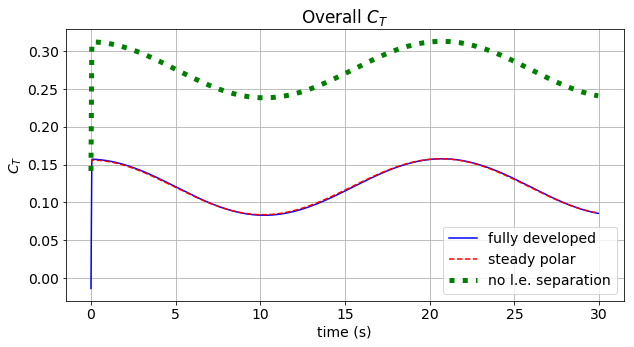

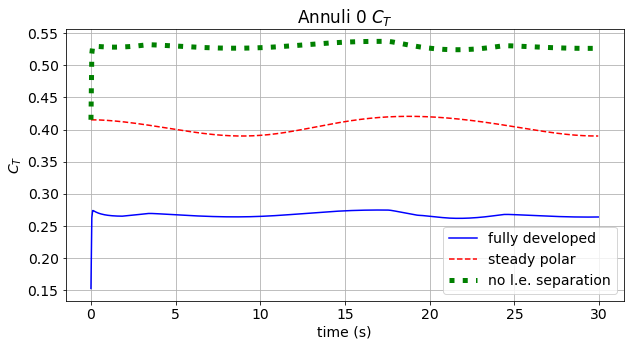

In [53]:
# plot the results
k=0
fig1 = plt.figure(1, figsize=(10,5))
plt.rcParams.update({'font.size': 14}) 
plt.title(r'Overall $C_{T}$')
plt.plot(time, CT_pp_ds-CT_pp_ds[1]/2, color='b', linestyle='-', label='fully developed')
plt.plot(time, CT_pp_s, color='r', linestyle='--', label='steady polar')
plt.plot(time, CT_pp_le, color='g', linestyle=':', linewidth=5,label='no l.e. separation')
plt.xlabel(r'time (s)')
plt.ylabel(r'$C_{T}$')
plt.grid()
plt.legend()
plt.show()

fig2 = plt.figure(2, figsize=(10,5))
plt.rcParams.update({'font.size': 14}) 
plt.title(r'Annuli {i} '.format(i=k)+'$C_{T}$')
plt.plot(time, Ct_pp_ds[k]-Ct_pp_ds[k][1]/2, color='b', linestyle='-', label='fully developed')
plt.plot(time, Ct_pp_s[k], color='r', linestyle='--', label='steady polar')
plt.plot(time, Ct_pp_le[k], color='g', linestyle=':', linewidth=5,label='no l.e. separation')
plt.xlabel(r'time (s)')
plt.ylabel(r'$C_{T}$')
plt.grid()
plt.legend()
plt.show()



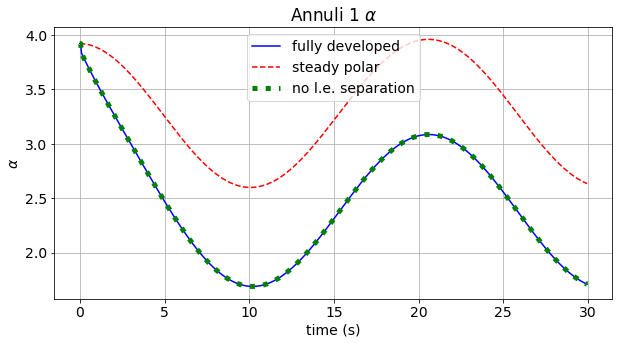

In [61]:
fig3 = plt.figure(3, figsize=(10,5))
plt.rcParams.update({'font.size': 14}) 
plt.title(r'Annuli {i} '.format(i=k)+r'$\alpha$')
plt.plot(time, alpha_pp_ds[k]*180/np.pi, color='b', linestyle='-', label='fully developed')
plt.plot(time, alpha_pp_s[k]*180/np.pi, color='r', linestyle='--', label='steady polar')
plt.plot(time, alpha_pp_le[k]*180/np.pi, color='g', linestyle=':', linewidth=5,label='no l.e. separation')
plt.xlabel(r'time (s)')
plt.ylabel(r'$\alpha$')
plt.grid()
plt.legend()
plt.show()

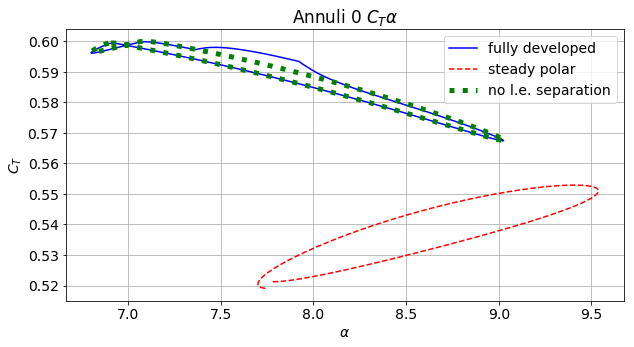

In [44]:
fig4 = plt.figure(4, figsize=(10,5))
#we will only plot the last cycle
omega = omega_R_uinf
n_of_cycle = time*omega/(2*np.pi) # calculate the phase of the different points of the cycle
i1=np.argmin(abs(time-(time[-1]-(2*np.pi)/omega))) # time -time of one cycle
i3 = len(time)


plt.rcParams.update({'font.size': 14}) 
plt.title(r'Annuli {i} '.format(i=k)+r'$C_{T} \alpha$')
plt.plot(alpha_pp_ds[k, i1:i3]*180/np.pi, Ct_pp_ds[k, i1:i3], color='b', linestyle='-', label='fully developed')
plt.plot(alpha_pp_s[k, i1:i3]*180/np.pi, Ct_pp_s[k, i1:i3], color='r', linestyle='--', label='steady polar')
plt.plot(alpha_pp_le[k, i1:i3]*180/np.pi, Ct_pp_le[k, i1:i3], color='g', linestyle=':', linewidth=5,label='no l.e. separation')
plt.ylabel(r'$C_{T}$')
plt.xlabel(r'$\alpha$')
plt.grid()
plt.legend()
plt.show()

In [ ]:
alpha_pp_ds[:,0]

In [93]:
alpha_pp_ds

array([[0.11865041, 0.1186415 , 0.1143901 , ..., 0.07875226, 0.07863986,
        0.07853787],
       [0.07931959, 0.07931248, 0.07768534, ..., 0.04713816, 0.04702926,
        0.04692913],
       [0.05565036, 0.05564551, 0.05482403, ..., 0.03165759, 0.03157073,
        0.03148996],
       [0.06646157, 0.06645803, 0.06596968, ..., 0.0471408 , 0.04705905,
        0.04698198],
       [0.07741638, 0.07741349, 0.07693524, ..., 0.06001993, 0.05994656,
        0.05987683]])

In [36]:
B_unsteady.pitch_time

array([-0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08726646,
       -0.08726646, -0.08726646, -0.08726646, -0.08726646, -0.08